#### COMPGW02 Web Economics - Coursework
# Online Advertising: Optimal Bidding Strategy
### Maximilian Bartolo
Date: 07 April 2017

## Introduction

This work concerns an online advertising problem. The objective is to help advertisers to form a bidding strategy in order to place their ads online in a real-time bidding system. The aim is to generate a model-driven algorithm capable of bidding in real-time based display advertising.

The performance of the model will be (mainly) evaluated on the Click-through Rate (CTR) achieved on the test set. Conversions (number of clicked bids) is also a significant factor.

Other contributing factors include:
* CVR (Conversion Rates)
* Spend (Total Money Paid)
* Average CPM (Cost per Mille)
* Average CPC (Cost per Click)

## Data Analytics
### Data Overview

The data is an extract from the iPinYou demand side platform (DSP) real-time bidding dataset.

### Importing Python Libraries
Let's start off my importing the libraries and packages we'll be using for our analysis as well as setting our default options.

In [1]:
# Importing the libraries
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import glob, re, random, itertools, time
from collections import Counter, defaultdict
from datetime import datetime, timedelta

# Importing additional required libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC, SVC, OneClassSVM
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# Set options
pd.set_option("display.max_colwidth", 1000)
# pd.options.mode.chained_assignment = None  # default='warn'

# Set a random seed for repeatability
rand_seed = 27
random.seed(rand_seed)
np.random.seed(rand_seed)

### Importing Data with Pandas
The dataset contains *train*, *validation* and *test* data files which all need to be imported.

In [2]:
# Importing the data
data_path_in = 'data/'
df_train = pd.read_csv(data_path_in + "train.csv")
df_val = pd.read_csv(data_path_in + "validation.csv")
df_test = pd.read_csv(data_path_in + "test.csv")

# Remove error data (as instructed)
df_train = df_train[df_train.bidprice >= df_train.payprice]

In [3]:
# Inspecting the data
df_train.head(2)

,click,weekday,hour,bidid,logtype,userid,useragent,IP,region,city,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,1,14,fdfae6789b787899f1b875de3ab8b21a,1,u_Vh1OPkFv3q5CFdR,windows_ie,180.107.112.*,80,85,...,60,1,0,5,612599432d200b093719dd1f372f7a30,300,54,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10063"
1,0,2,20,372883147cdefbc495fb5082f79dde9b,1,u_VhkRL6dCOTLsq-c,windows_chrome,125.120.199.*,94,95,...,250,1,0,5,8dff45ed862a740986dbe688aafee7e5,249,42,15b749127478946f161a54dc0dad27c8,3476,"10063,10111"


### Cleaning the Data

By analyzing and understanding the structure and content of the available data, we can determine which variables would add value to our model and business case. We therefore drop any columns which cannot be used for our prediction model or which provide no added value.

We remove the following columns for the reasons below:
* logtype - all values are 1
* userid - 2558996 unique out of 2664159
* urlid - all values are null

In [4]:
# Cleaning the dataset
cols_to_remove = ['logtype', 'userid', 'urlid']
cols_of_interest = [col for col in list(df_train.columns) if col not in cols_to_remove]
df_train = df_train[cols_of_interest]
df_val = df_val[cols_of_interest]

# For the test set, there are less columns than the other two datasets
cols_of_interest = [col for col in list(df_test.columns) if col not in cols_to_remove]
df_test = df_test[cols_of_interest]

### Summary Statistics

In [5]:
# Get more information about the dataframe
df_train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2664159 entries, 0 to 2697737
Data columns (total 23 columns):
click             2664159 non-null int64
weekday           2664159 non-null int64
hour              2664159 non-null int64
bidid             2664159 non-null object
useragent         2664159 non-null object
IP                2664159 non-null object
region            2664159 non-null int64
city              2664159 non-null int64
adexchange        2664159 non-null object
domain            2664159 non-null object
url               2664159 non-null object
slotid            2664159 non-null object
slotwidth         2664159 non-null int64
slotheight        2664159 non-null int64
slotvisibility    2664159 non-null object
slotformat        2664159 non-null object
slotprice         2664159 non-null int64
creative          2664159 non-null object
bidprice          2664159 non-null int64
payprice          2664159 non-null int64
keypage           2664159 non-null object
advertiser     

In [6]:
# Get descriptive statistics about the dataframe
df_train.describe()

,click,weekday,hour,region,city,slotwidth,slotheight,slotprice,bidprice,payprice,advertiser
count,2.664159e+06,2.664159e+06,2.664159e+06,2.664159e+06,2.664159e+06,2.664159e+06,2.664159e+06,2.664159e+06,2.664159e+06,2.664159e+06,2.664159e+06
mean,7.454510e-04,2.889097e+00,1.349015e+01,1.495184e+02,1.544642e+02,5.774678e+02,1.884807e+02,2.673956e+01,2.729818e+02,7.814598e+01,2.840225e+03
std,2.729278e-02,2.055271e+00,6.568752e+00,1.020634e+02,1.033031e+02,3.216016e+02,1.312695e+02,3.706526e+01,2.890392e+01,5.984167e+01,7.845256e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.200000e+02,5.000000e+01,0.000000e+00,2.270000e+02,0.000000e+00,1.458000e+03
25%,0.000000e+00,1.000000e+00,1.000000e+01,7.900000e+01,7.900000e+01,3.000000e+02,9.000000e+01,0.000000e+00,2.410000e+02,3.300000e+01,2.259000e+03
50%,0.000000e+00,3.000000e+00,1.400000e+01,1.460000e+02,1.520000e+02,3.360000e+02,9.000000e+01,5.000000e+00,2.940000e+02,6.800000e+01,3.358000e+03
75%,0.000000e+00,5.000000e+00,1.900000e+01,2.160000e+02,2.220000e+02,9.600000e+02,2.500000e+02,5.000000e+01,3.000000e+02,9.900000e+01,3.427000e+03
max,1.000000e+00,6.000000e+00,2.300000e+01,3.950000e+02,3.990000e+02,1.000000e+03,6.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,3.476000e+03


### Dealing with Missing Data

From the summary statistics, it could be observed that none of the training data has missing values, however, on further observation we notice that missing values do exist in the data and are stored as string representations such as *null* or *na*, therefore, we replace all string representations with actuall *NULL* values.

In [7]:
#replace all "null" occurrences with np.nan
list_replace_from = ['null', 'Na', 'nan']
list_replace_to = [np.nan] * len(list_replace_from)

df_train = df_train.replace(list_replace_from, list_replace_to)
df_val = df_val.replace(list_replace_from, list_replace_to)
df_test = df_test.replace(list_replace_from, list_replace_to)

#### Imputing Missing Values

Since we know that the *bidprice*, *payprice* and *click* features which are not present in the *test* dataset do not have missing values, we can impute on the remaining columns. We choose to replace missing values with the feature median and the most common value for non-numeric data types. We could do more advanced imputation such as predicting missing values through regression techniques, however, given the small amount of actual missing values in the dataset, this was deemed unnecessary at this stage.

In [8]:
# Impute missing values
for col in df_test.columns.values:
    # Using whole data to form an exhaustive list of values from which to extract median
    data = df_train[col].append(df_val[col]).append(df_test[col])
    
    if df_test[col].dtypes == 'object':
        median_val = data.value_counts().index[0]
    else:
        median_val = data.median()
        
    # apply the imputation
    df_train[col].fillna(median_val, inplace=True)
    df_val[col].fillna(median_val, inplace=True)
    df_test[col].fillna(median_val, inplace=True)

### Feature Engineering

Given the data structure, we can extract or manipulate features which could provide added value to our prediction model.

#### Price Bucketing
We start by creating 5 price bands and allocating every data sample into one of these bands.

In [9]:
def get_buckets(price):
    if price == 0:
        return [1,0,0,0,0]
    elif price > 0 and price <= 10:
        return [0,1,0,0,0]
    elif price > 10 and price <= 50:
        return [0,0,1,0,0]
    elif price > 50 and price <=100:
        return [0,0,0,1,0]
    elif price > 100:
        return [0,0,0,0,1]
    
df_train["slotprice_0"],df_train["slotprice_1_10"],df_train["slotprice_11_50"],df_train["slotprice_50_100"],df_train["slotprice_50"] = zip(*df_train.slotprice.map(get_buckets))
df_val["slotprice_0"],df_val["slotprice_1_10"],df_val["slotprice_11_50"],df_val["slotprice_50_100"],df_val["slotprice_50"] = zip(*df_val.slotprice.map(get_buckets))
df_test["slotprice_0"],df_test["slotprice_1_10"],df_test["slotprice_11_50"],df_test["slotprice_50_100"],df_test["slotprice_50"] = zip(*df_test.slotprice.map(get_buckets))

#### Browser and OS separation
We separate browser and operating system into two separate features.

In [10]:
df_train["os"],df_train["browser"] = zip(*df_train.useragent.map(lambda x: x.split("_")))
df_val["os"],df_val["browser"] = zip(*df_val.useragent.map(lambda x: x.split("_")))
df_test["os"],df_test["browser"] = zip(*df_test.useragent.map(lambda x: x.split("_")))

#### Slot Area
We define the slot area as the slot width multiplied by the slot height.

In [11]:
df_train["slotarea"] = df_train["slotheight"]*df_train["slotwidth"]
df_val["slotarea"] = df_val["slotheight"]*df_val["slotwidth"]
df_test["slotarea"] = df_test["slotheight"]*df_test["slotwidth"]

#### One-Hot Encoding of Usertags
Usertags are currently stored as a comma separated string which cannot be accessed as separate features by our model, only as a combination of usertags. Therefore, to provide the model with greater flexibility we perform one-hot encoding of the separated usertags, essentially creating a new feature for every usertag. The sparsity of the new data structure doesn't hinder model performance too much but provides significantly improved ability for feature manipulation.

We begin by identifying all the unique usertags in the data.

In [12]:
data = df_train.append(df_val).append(df_test)
import itertools
list_usertags = [x.split(',') for x in data.usertag.values if x is not np.nan]
joined_usertags = list(itertools.chain.from_iterable(list_usertags))
unique_usertags = sorted(list(set(joined_usertags)))

# Results below to speed up processing
# unique_usertags = ['10006', '10024', '10031', '10048', '10052', '10057', '10059', '10063', '10067', '10074', '10075', '10076', '10077', '10079', '10083', '10093', '10102', '10110', '10111', '10114', '10115', '10116', '10117', '10118', '10120', '10123', '10125', '10126', '10127', '10129', '10130', '10131', '10133', '10138', '10140', '10142', '10145', '10146', '10147', '10148', '10149', '10684', '11092', '11278', '11379', '11423', '11512', '11576', '11632', '11680', '11724', '11944', '13042', '13403', '13496', '13678', '13776', '13800', '13866', '13874', '14273', '15398', '16593', '16617', '16661', '16706', '16751', '16753']

Next we create a new column for every usertag and initialize that to the default value of 0, indicating that particular usertag is not present in the *usertag* string list.

In [13]:
#Add the usertags as columns in the dataframes
for usertag_id in unique_usertags: # Add a column for each unique usertag
    df_train["usertag_" + usertag_id] = int(0)
    df_val["usertag_" + usertag_id] = int(0)
    df_test["usertag_" + usertag_id] = int(0)

Then we populate the usertags for each of the three datasets using a lambda function.

In [17]:
#Populate the usertags for each dataframe
for usertag_id in unique_usertags:
    df_train["usertag_" + usertag_id] = df_train.apply(lambda x: 1 if ((x["usertag"] is not np.nan) and \
                                                                       (usertag_id in x["usertag"].split(','))) else 0, axis=1)
    df_val["usertag_" + usertag_id] = df_val.apply(lambda x: 1 if ((x["usertag"] is not np.nan) and \
                                                                   (usertag_id in x["usertag"].split(','))) else 0, axis=1)
    df_test["usertag_" + usertag_id] = df_test.apply(lambda x: 1 if ((x["usertag"] is not np.nan) and \
                                                                     (usertag_id in x["usertag"].split(','))) else 0, axis=1)

Next we save and store our cleaned and feature engineered datasets in order to clear up memory and speed up processing for our Exploratory Data Analysis.

In [18]:
# Saving the data
data_path_out = 'data/'
df_train.to_csv(data_path_out + "train_clean.csv", encoding="utf-8", index=False)
df_val.to_csv(data_path_out + "validation_clean.csv", encoding="utf-8", index=False)
df_test.to_csv(data_path_out + "test_clean.csv", encoding="utf-8", index=False)

### Exploratory Data Analysis

With our dataset prepared, we will begin exploratory analysis. This iterative process will help us in building our models.

In [4]:
# First we import the cleaned and pre-processed data
data_path_in = 'data/'
df_train = pd.read_csv(data_path_in + "train_preprocessed.csv")
df_val = pd.read_csv(data_path_in + "validation_preprocessed.csv")
df_test = pd.read_csv(data_path_in + "test_preprocessed.csv")

First, we compare click ratios in the *train* and *validation* datasets to ensure that they are similarly distributed.

In [7]:
print ("Click Ratio in the training data is: {:.4f}%".format(len(df_train[df_train.click==1])*100/len(df_train)))
print ("Click Ratio in the validation data is: {:.4f}%".format(len(df_val[df_val.click==1])*100/len(df_val)))

Click Ratio in the training data is: 0.0745%
Click Ratio in the validation data is: 0.0754%


We observe that training and validation data are similar. Therefore, we carry out all our exploratory analysis on the training data as that represents the bulk of data available.

Let's take a look at the distribution of data within our features to understand how they could be of interest.

#### Web Browser and OS Usage

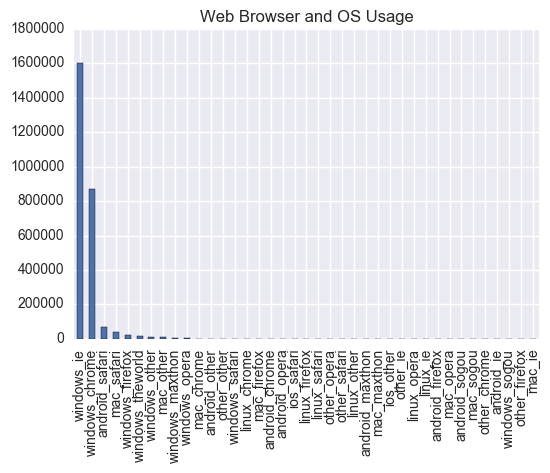

In [11]:
df_train.useragent.value_counts().plot(kind='bar')
plt.title("Web Browser and OS Usage")
plt.show()

#### Ad Slot Area

Now, we take a look at which slot areas are most popular.

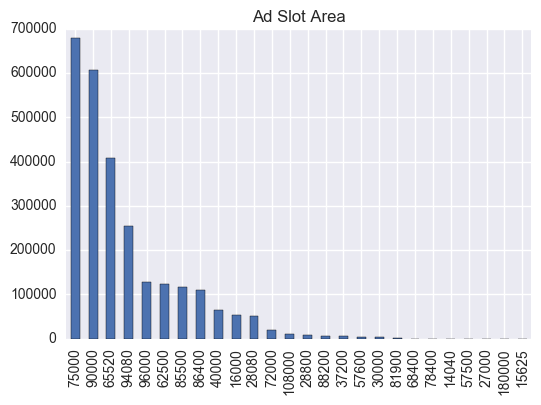

In [12]:
df_train.slotarea.value_counts().plot(kind='bar')
plt.title("Ad Slot Area")
plt.show()

#### Bid Price and Pay Price Distribution
Let's try to understand how bid price and pay price are distributed in the data.

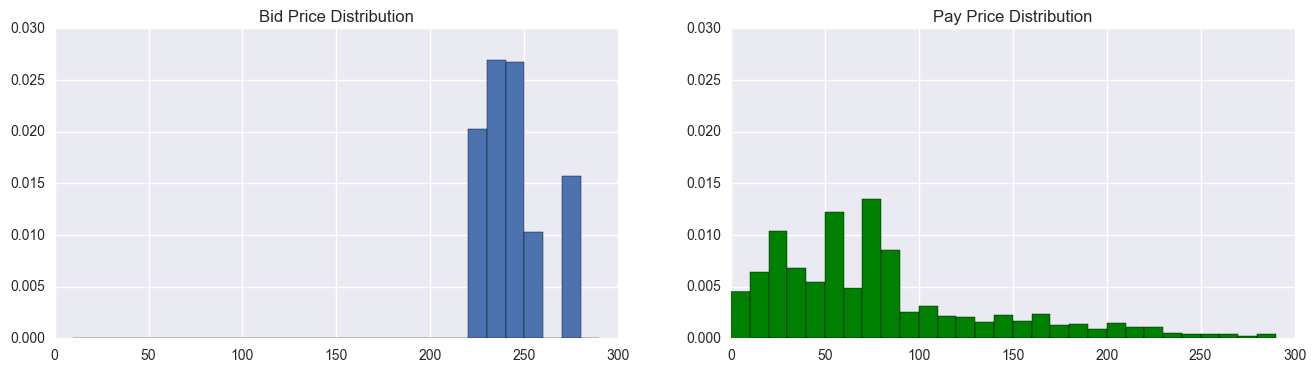

In [21]:
fig = plt.figure(1, figsize=(16, 4))

xlim = [0, 300]
ylim = [0, 0.03]
bins = np.arange(0,300,10)

ax = plt.subplot(1,2,1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
df_train.bidprice.hist(bins=bins, normed=True)
plt.title("Bid Price Distribution")

ax = plt.subplot(1,2,2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
df_train.payprice.hist(bins=bins, normed=True, color="green")
plt.title("Pay Price Distribution")

plt.show()

We immediately notice a difference in distributions between the bid price and pay price. While bid price is shifted towards the right of the distribution very clearly, there is a wide range of prices you would actually have to pay to win a particular ad impression. This could indicate an opportunity for optimization of our models as we could combine bidding on those ads we would expect to be most likely to be clicked with our predictions for pay price (as this is not provided in real-time).

On making this observation, we can get a visual indication of whether this hypothesis could be valid by plotting all click values with their payprice in a box plot and observing whether clicks were distributed throughout this range or whether they existed only at a particular pay price range.

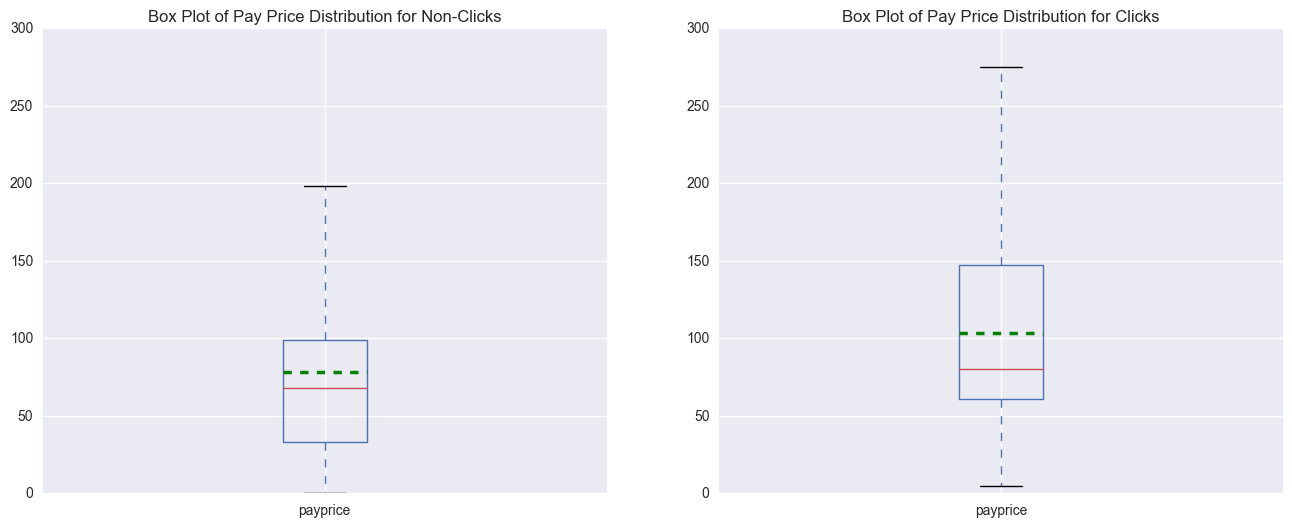

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16,6))

meanlineprops = dict(linestyle='--', linewidth=2.5, color='green')

ax = plt.subplot(1,2,1)
df_train.payprice[df_train.click == 0].plot.box(showmeans=True, meanline=True, meanprops=meanlineprops)
plt.title('Box Plot of Pay Price Distribution for Non-Clicks')

ax = plt.subplot(1,2,2)
df_train.payprice[df_train.click == 1].plot.box(showmeans=True, meanline=True, meanprops=meanlineprops)
plt.title('Box Plot of Pay Price Distribution for Clicks')

plt.show()

We observe that although the distribution for clicks is slightly higher than for non-clicks, there is still quite a large active pay price range where clicks occur and median pay price values (solid red line) are indeed quite similar. This gives further evidence that taking a predicted pay price value into consideration in our bidding strategy could be beneficial. There is also a slight shift in mean values (dashed green line) between the two.

Let's compare actual median and mean pay-price values for clicks and non-clicks.

In [30]:
print ("Median pay price value for non-clicks: {:.2f}".format(df_train.payprice[df_train.click == 0].median()))
print ("Median pay price value for clicks: {:.2f}".format(df_train.payprice[df_train.click == 1].median()))
print ()
print ("Mean pay price value for non-clicks: {:.2f}".format(df_train.payprice[df_train.click == 0].mean()))
print ("Mean pay price value for clicks: {:.2f}".format(df_train.payprice[df_train.click == 1].mean()))

Median pay price value for non-clicks: 68.00
Median pay price value for clicks: 80.00

Mean pay price value for non-clicks: 78.13
Mean pay price value for clicks: 103.32


#### Variation of Pay Price and Click Rate by Day of Week
Let's take a look at how Click Rate and Pay Price vary with Day of Week.

In [53]:
list_click_rate = []
list_pay_price = []
days_of_week = sorted(df_train.weekday.unique())

In [54]:
for day in days_of_week:
    list_click_rate.append(len(df_train.click[df_train.click == 1][df_train.weekday == day])*100/ \
                           len(df_train.click[df_train.weekday == day]))
    list_pay_price.append(df_train.payprice[df_train.weekday == day].mean())

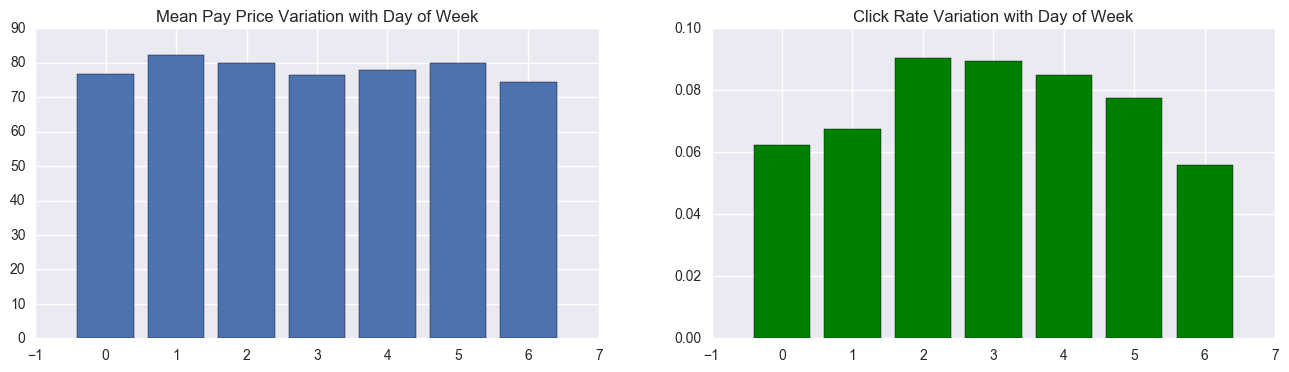

In [55]:
fig = plt.figure(1, figsize=(16, 4))

xlim = [min(days_of_week)-1, max(days_of_week)+1]

ax = plt.subplot(1,2,1)
ax.set_xlim(xlim)
plt.bar(days_of_week, list_pay_price, align="center")
plt.title("Mean Pay Price Variation with Day of Week")

ax = plt.subplot(1,2,2)
ax.set_xlim(xlim)
plt.bar(days_of_week, list_click_rate, color="green", align="center")
plt.title("Click Rate Variation with Day of Week")

plt.show()

We observe that mean Pay Price doesn't appear to vary much with day of week, however, click rate does with a visible increase in the middle section of the plot. Although we don't know what these values correspond to so we cannot identify whether this is during mid-week or weekend for example, we can identify that this feature could be useful in predicting whether an impression will result in a click or not.

#### Variation of Pay Price and Click by Hour of Day
Let's take a look at how Click Rate and Pay Price vary with Hour of Day.

In [56]:
list_click_rate = []
list_pay_price = []
hours_of_day = sorted(df_train.hour.unique())

In [57]:
for hour in hours_of_day:
    list_click_rate.append(len(df_train.click[df_train.click == 1][df_train.hour == hour])*100/ \
                           len(df_train.click[df_train.hour == hour]))
    list_pay_price.append(df_train.payprice[df_train.hour == hour].mean())

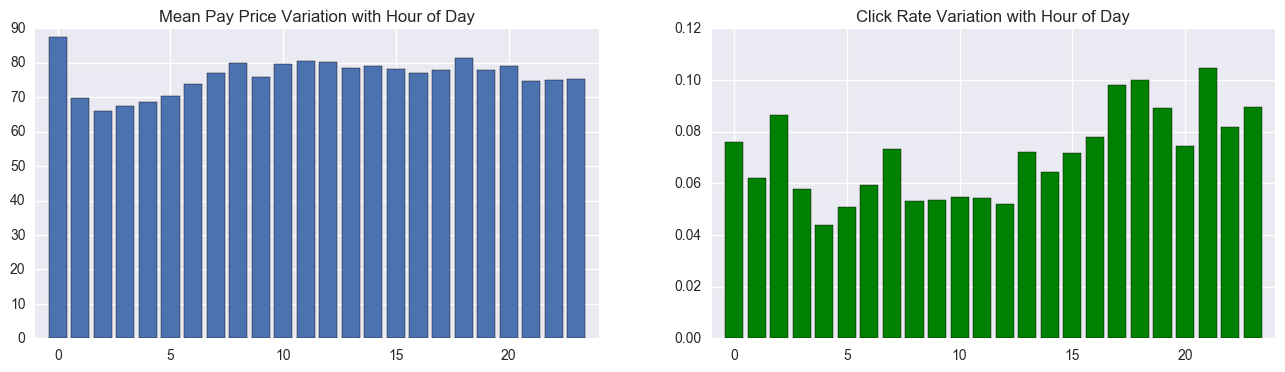

In [58]:
fig = plt.figure(1, figsize=(16, 4))

xlim = [min(hours_of_day)-1, max(hours_of_day)+1]

ax = plt.subplot(1,2,1)
ax.set_xlim(xlim)
plt.bar(hours_of_day, list_pay_price, align="center")
plt.title("Mean Pay Price Variation with Hour of Day")

ax = plt.subplot(1,2,2)
ax.set_xlim(xlim)
plt.bar(hours_of_day, list_click_rate, color="green", align="center")
plt.title("Click Rate Variation with Hour of Day")

plt.show()

Here we observe minimal variation for pay price for hour of day but a visually significant amounf of of variation in click rates.

#### Variation of Pay Price and Click Rate by Ad Exchange
Let's take a look at how Click Rate and Pay Price vary by Ad Exchange.

In [59]:
list_click_rate = []
list_pay_price = []
items = sorted(df_train.adexchange.unique())

In [60]:
for item in items:
    list_click_rate.append(len(df_train.click[df_train.click == 1][df_train.adexchange == item])*100/ \
                           len(df_train.click[df_train.adexchange == item]))
    list_pay_price.append(df_train.payprice[df_train.adexchange == item].mean())

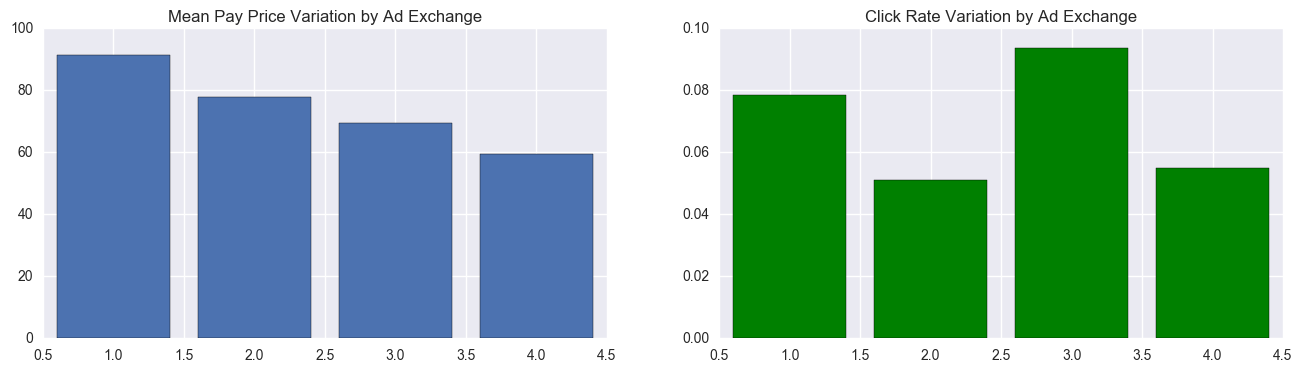

In [61]:
fig = plt.figure(1, figsize=(16, 4))

ax = plt.subplot(1,2,1)
plt.bar(items, list_pay_price, align="center")
plt.title("Mean Pay Price Variation by Ad Exchange")

ax = plt.subplot(1,2,2)
plt.bar(items, list_click_rate, color="green", align="center")
plt.title("Click Rate Variation by Ad Exchange")

plt.show()

Here we observe that both pay price and click rate vary with ad exchange.

#### Variation of Pay Price and Click Rate by Advertiser
Let's take a look at how Click Rate and Pay Price vary by Advertiser.

In [67]:
list_click_rate = []
list_pay_price = []
items = sorted(df_train.advertiser.unique())
items_string = [str(x) for x in items]

In [68]:
for item in items:
    list_click_rate.append(len(df_train.click[df_train.click == 1][df_train.advertiser == item])*100/ \
                           len(df_train.click[df_train.advertiser == item]))
    list_pay_price.append(df_train.payprice[df_train.advertiser == item].mean())

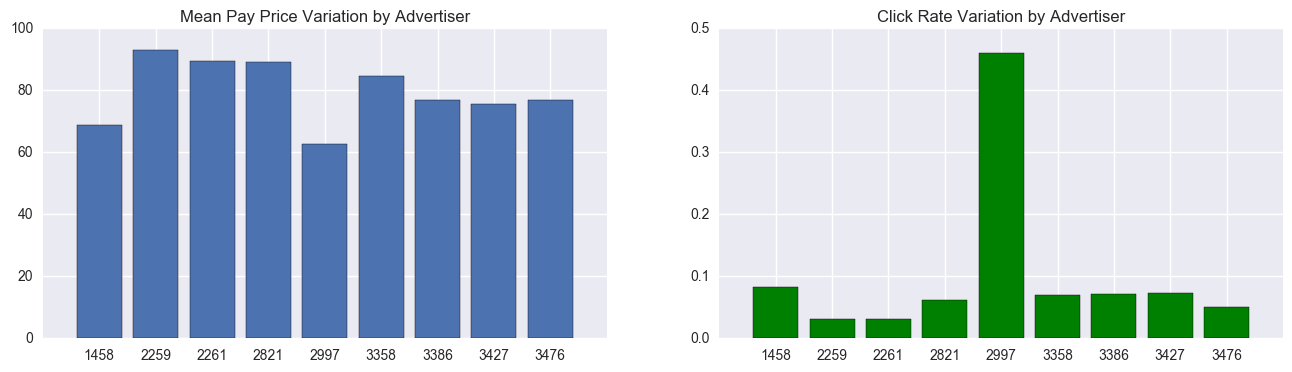

In [71]:
fig = plt.figure(1, figsize=(16, 4))

ax = plt.subplot(1,2,1)
plt.bar(range(len(items)), list_pay_price, align="center", tick_label=items_string)
plt.title("Mean Pay Price Variation by Advertiser")

ax = plt.subplot(1,2,2)
plt.bar(range(len(items)), list_click_rate, color="green", align="center", tick_label=items_string)
plt.title("Click Rate Variation by Advertiser")

plt.show()

We observe some variation in mean pay price distribution, however, most notable is the extremely high click rate for advertiser *2997*. Keeping this in mind, we also observe that the same advertiser has the lowest mean pay price. This could be an indication that this advertiser is optimizing both pay price predictions and click rate in its bidding strategy.

With this in mind, let's take a look at the number of clicks and impressions won for each advertiser.

In [73]:
list_clicks = []
list_impressions = []
items = sorted(df_train.advertiser.unique())
items_string = [str(x) for x in items]

In [74]:
for item in items:
    list_clicks.append(len(df_train.click[df_train.click == 1][df_train.advertiser == item]))
    list_impressions.append(len(df_train.click[df_train.advertiser == item]))

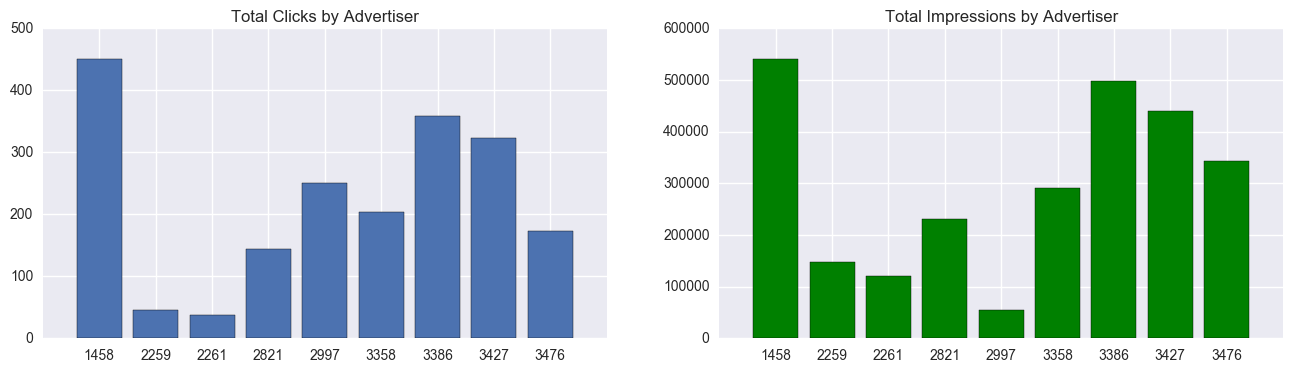

In [75]:
fig = plt.figure(1, figsize=(16, 4))

ax = plt.subplot(1,2,1)
plt.bar(range(len(items)), list_clicks, align="center", tick_label=items_string)
plt.title("Total Clicks by Advertiser")

ax = plt.subplot(1,2,2)
plt.bar(range(len(items)), list_impressions, color="green", align="center", tick_label=items_string)
plt.title("Total Impressions by Advertiser")

plt.show()

We observe that the advertiser with the best previous CTR performance, advertiser *2997*, has the least number of impressions but is still bidding on a relatively high number of clicks compared to the other advertisers. Therefore, we make the assumption that the strategy this advertiser is using is allowing it to win a greater rate of impressions which translate into clicks, thus predicting whether or not an impression will result in a click should be of benefit to our model.

#### Usertag Counts
While we have explored the majority of interesting variables in the data, we have also extracted and one-hot encoded the *usertag* variable into separate features. It could be interesting to analyze which usertags appear most often.

In [81]:
unique_usertags = ['10006', '10024', '10031', '10048', '10052', '10057', '10059', '10063', '10067', '10074', '10075', '10076', '10077', '10079', '10083', '10093', '10102', '10110', '10111', '10114', '10115', '10116', '10117', '10118', '10120', '10123', '10125', '10126', '10127', '10129', '10130', '10131', '10133', '10138', '10140', '10142', '10145', '10146', '10147', '10148', '10149', '10684', '11092', '11278', '11379', '11423', '11512', '11576', '11632', '11680', '11724', '11944', '13042', '13403', '13496', '13678', '13776', '13800', '13866', '13874', '14273', '15398', '16593', '16617', '16661', '16706', '16751', '16753']
usertag_features = ["usertag_" + usertag for usertag in unique_usertags]

In [83]:
list_counts = []
items = usertag_features

for item in items:
    list_counts.append(len(df_train.click[df_train[item] == 1]))

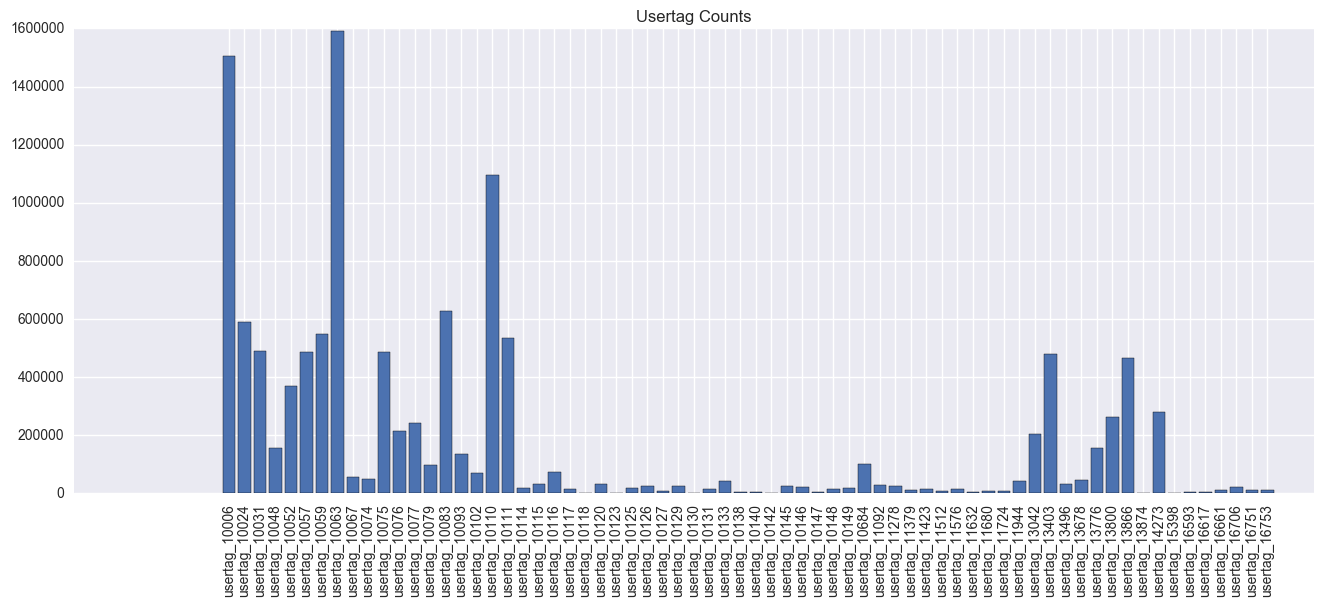

In [85]:
fig = plt.figure(1, figsize=(16, 6))

ax = plt.subplot(1,1,1)
plt.bar(range(len(items)), list_counts, align="center", tick_label=items)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90) #rotate tick labels
plt.title("Usertag Counts")

plt.show()

We observe that the usertag distribution is heavy-tailed in that a few of the usertags have very high counts while a large proportion of usertags have relatively few counts.

#### Usertag Correlations
It could also be interesting to analyze whether any correlations exist between these usertags.

In [109]:
cur_plot = 0
def plot_correlation_matrix(corr, num_rows=1, num_columns=1):
    global cur_plot
    if cur_plot == 0:        
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(num_columns*10, num_rows*10))
    
    cur_plot += 1
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    ax = plt.subplot(num_rows, num_columns, cur_plot)
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.set(font_scale=1.8)
    with sns.axes_style("white"):
        sns.heatmap(corr,  mask=mask, cmap=cmap,
                square=True, 
                #xticklabels=corr.columns.values,
                #yticklabels=corr.columns.values,
                linewidths=.5, cbar_kws={"shrink": .8},
                #annot=True #annotates values onto the plot
                )

In [ ]:
# Generate the correlation matrix
correlation_matrices = {}
method = 'kendall' #method : {‘pearson’, ‘kendall’, ‘spearman’}
        
correlation_matrices[method] = df_train[usertag_features].corr(method=method)

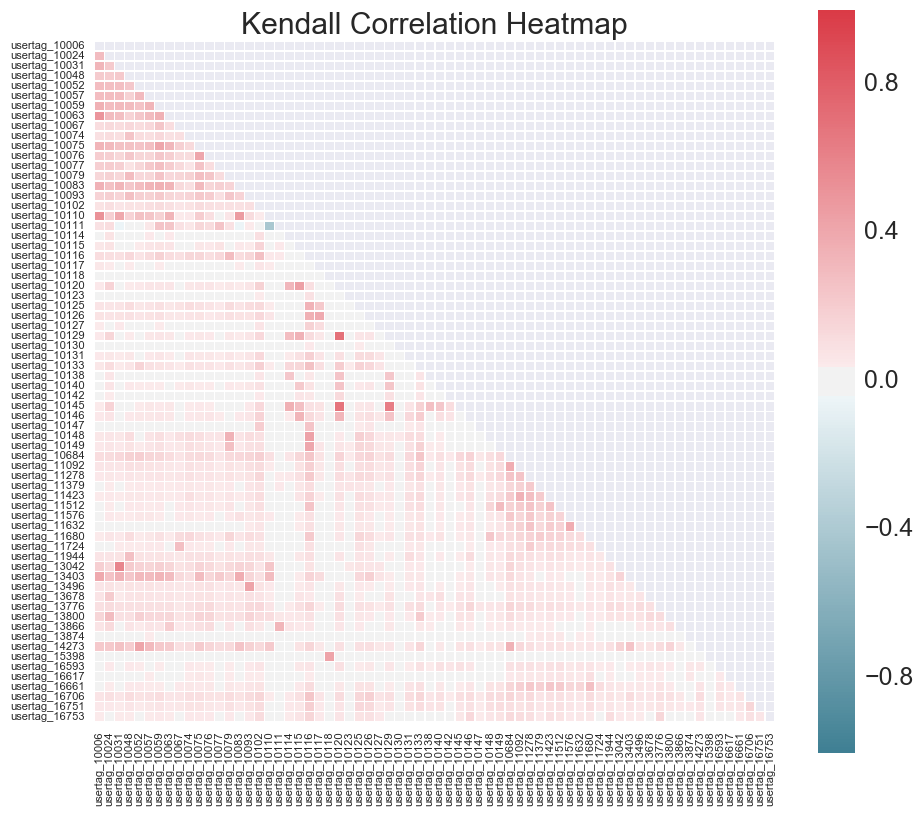

In [110]:
# Plot the heatmap
plot_correlation_matrix(correlation_matrices[method])
plt.title(method.title() + " Correlation Heatmap")
plt.tight_layout()

From the correlation matrix, we observe various high positive correlations, such as those between *usertag_10120* and *usertag_10129* or between *usertag_10129* and *usertag_10145*. We also notice that there is not much negative correlation, however, the correlation between *usertag_10110* and *usertag_10111* stands out in particular in this regard.

## Building the Model

### Overview

Due to the large amount of data and computational expense of training, optimizing and cross-validating such large models, we will take a randomly selected subset of the data to identify the best model and hyper-parameters. We analyze different subset volumes to see at which point we can safely sub-sample without compromising the model. We find that this is at a point where the subsampled training data contains all the outliers (clicks) and approximately 15,000 inliers (non-clicks), significantly undersampling to raise the anomaly ratio.

We are opting for a One-Class SVM model which is specifically designed to detect anomalies. From initial testing we notice that our data is not linearly separable and this, a polynomial kernel, while being significantly faster, is of little use. Therefore, we opt for the more complex and significantly computationally slower RBF (Gaussian Radial Base Function) Kernel.

### Feature Encoding
We must first encode all our features from strings or objects to integer values. We could also One-Hot Encode such features to remove ordinality within the data and achieve orthogonality in the vector space, however, this comes at the expense of increasing the number of features, which would have a significant impact on our computation time.

We start by excluding the usertag features as we know that these are already encoded and scaled as well as the features we cannot use for modelling.

In [8]:
features_to_process = df_test.columns.values
features_to_process = [x for x in features_to_process if "usertag_" not in x]

features_to_exclude = ['click', 'bidid', 'bidprice', 'payprice']
features_to_process = [x for x in features_to_process if x not in features_to_exclude]

Next, we apply the encoding and store all the encoders in case we want to decode at a later point. We have to ensure that our encoder is fit on the entire combination of the three datasets so that it knows how to encode every value in the data.

In [11]:
#Label encode and scale all features
le = {}

for col in features_to_process:
    # Encoding only categorical variables
    if df_test[col].dtypes == 'object':
        # Using whole data to form an exhaustive list of levels
        data = df_train[col].append(df_val[col]).append(df_test[col])
        
        le[col] = preprocessing.LabelEncoder() #define and store a label encoder for every column so we can inverse_transform
        le[col].fit(data.values)
        
        df_train[col] = le[col].transform(df_train[col])
        df_val[col] = le[col].transform(df_val[col])        
        df_test[col] = le[col].transform(df_test[col])

### Feature Scaling
There are various methods for carrying out feature scaling. While scaling to zero mean, unit variance is generally prepared, we found that scale all values between the minimum and maximum values in the data gave slightly improved performance. Scaling is used to ensure that particular features are not given excessive weighting such that the importance of other features is diminished a priori to building the model.

In [12]:
#new feature scaling to keep dataframe format
ss = {}
do_scale = True
        
if do_scale:
    for col in features_to_process:
        data = df_train[col].append(df_val[col]).append(df_test[col])

        ss[col] = preprocessing.MinMaxScaler() #define and store a label encoder for every column so we can inverse_transform  
        ss[col].fit(data.values)
        
        if col in df_train.columns.values:
            df_train[col] = ss[col].transform(df_train[col])
            df_val[col] = ss[col].transform(df_val[col])
            
        if col in df_test.columns.values:
            df_test[col] = ss[col].transform(df_test[col])

C:\Users\Max\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\p

We export the data again in order to avoid repeating all this time intensive processing.

In [15]:
# Saving the data
data_path_out = 'data/'
df_train.to_csv(data_path_out + "train_preprocessed_model.csv", encoding="utf-8", index=False)
df_val.to_csv(data_path_out + "validation_preprocessed_model.csv", encoding="utf-8", index=False)
df_test.to_csv(data_path_out + "test_preprocessed_model.csv", encoding="utf-8", index=False)

### Data Manipulation and Preparation
Let's start by re-importing the data.

In [3]:
# First we import the cleaned and pre-processed data
data_path_in = 'data/'
df_train = pd.read_csv(data_path_in + "train_preprocessed_model.csv")
df_val = pd.read_csv(data_path_in + "validation_preprocessed_model.csv")
df_test = pd.read_csv(data_path_in + "test_preprocessed_model.csv")

#### Creating Development Data
We extract data from the training data in the exact format of the validation data as our development data which is what we will use to optimize our model on (this leaves the validation data for validation of the results we would expect on the test set).

In [4]:
print ("The validation data contains {} non-clicks".format(len(df_val[df_val.click == 0])))
print ("The validation data contains {} clicks".format(len(df_val[df_val.click == 1])))
print ("Total: {} data points".format(len(df_val)))

The validation data contains 299523 non-clicks
The validation data contains 226 clicks
Total: 299749 data points


In [5]:
cut_point = len(df_train)-299749
df_dev = df_train[cut_point:].copy()
df_train = df_train[:cut_point]

In [6]:
print ("The development data contains {} non-clicks".format(len(df_dev[df_dev.click == 0])))
print ("The development data contains {} clicks".format(len(df_dev[df_dev.click == 1])))
print ("Total: {} data points".format(len(df_dev)))

The development data contains 299519 non-clicks
The development data contains 230 clicks
Total: 299749 data points


#### Data Undersampling
We select all the clicks in the training data and 15,000 non-clicks on which to build our model.

In [7]:
features_to_process = df_test.columns.values
features_remove = ['click', 'bidid', 'logtype', 'userid', 'urlid', 'bidprice', 'payprice', 'usertag']
features = [x for x in features_to_process if x not in features_remove]
classification_column = 'click'

In [8]:
num_to_sample = 15000

#Full datasets
# X_train_full = df_train[features]
X_val_full = df_val[features]
X_dev_full = df_dev[features]
X_test = df_test[features]


#Training
df_train_sample = df_train.sample(num_to_sample, random_state=rand_seed)
X_train_inliers = df_train_sample[features][df_train.click == 0]
y_train_inliers = df_train_sample[classification_column][df_train.click == 0]

X_train_outliers = df_train[features][df_train.click == 1]
y_train_outliers = df_train[classification_column][df_train.click == 1]

X_train = X_train_inliers
y_train = y_train_inliers

#Validation
X_val_inliers = df_val[features][df_val.click == 0]
y_val_inliers = df_val[classification_column][df_val.click == 0]

X_val_outliers = df_val[features][df_val.click == 1]
y_val_outliers = df_val[classification_column][df_val.click == 1]

C:\Users\Max\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Feature Selection (Recursive Feature Elimination)
We perform Recursive Feature Elimination in order to obtain the set of features which provide the best score on the validation set. Common scoring functions include precision, recall, F-score or Area Under the Curve (AUC), however, essential for our model is the proportion of clicks it can properly correct (True Positives) against the proportion of non-clicks it believes are outliers/clicks (False Positives). Since True and False Negatives have very little impact on our bidding strategy as we are simply ignoring all negative predictions, we use this ratio as our scoring function.

In [ ]:
# Initiate the variables for Recursive Feature Elimination

do_remnant = False #This is a flag for remnant analysis (described below)

list_features = features.copy()
list_features_remove = []
num_i = len(list_features)

results_dict = {}

In [ ]:
true_val_click = np.array(list(df_val['click']))

if do_remnant:
    true_val_remnants = np.array(list(df_val['click_remnants']))

cur_i = 0
def da_ocsvm_model(features=[]):
    global results_dict
    global cur_i
    
    results_dict[cur_i] = {}
    results_dict[cur_i]['features'] = features
    
    start_time = time.time()
    one_class_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
    one_class_svm.fit(X_train[features])
    
    if not do_remnant:
        y_pred_val_inliers = one_class_svm.predict(X_val_inliers[features])
        y_pred_val_outliers = one_class_svm.predict(X_val_outliers[features])
    else:
        y_pred_val_full = one_class_svm.predict(X_val_full[features])
    
    end_time = time.time()
    print ("Time taken: {:.2f}s".format(end_time - start_time))    
    
    if not do_remnant:
        num_outliers_as_outliers = len(np.extract(y_pred_val_outliers == -1, y_pred_val_outliers))
        perc_clean_as_outliers = len(np.extract(y_pred_val_inliers == -1, y_pred_val_inliers))*100/len(y_pred_val_inliers)
        perc_outliers_as_outliers = num_outliers_as_outliers*100/len(y_pred_val_outliers)
    else:
        #REMNANT VALIDATION - START
        # Compare predited outliers (-1) with click remnants (1) 
        num_clean_as_outliers = np.sum(np.logical_and(y_pred_val_full == -1, true_val_click == 0))
        num_outliers_as_outliers = np.sum(np.logical_and(y_pred_val_full == -1, true_val_remnants == 1))
        
        perc_clean_as_outliers = num_clean_as_outliers*100/(true_val_click == 0).sum()
        perc_outliers_as_outliers = num_outliers_as_outliers*100/(true_val_click == 1).sum()
    
    score_ratio = perc_outliers_as_outliers/perc_clean_as_outliers
    
    results_dict[cur_i]['num_outliers_as_outliers'] = num_outliers_as_outliers
    results_dict[cur_i]['perc_clean_as_outliers'] = perc_clean_as_outliers
    results_dict[cur_i]['perc_outliers_as_outliers'] = perc_outliers_as_outliers
    results_dict[cur_i]['score_ratio'] = score_ratio
    
    cur_i += 1
    
    print ("Score: {:.4f}  |  % Out as out: {:.4f}  |  Num Outliers Detected: {}  |  Features: {}" \
           .format(score_ratio, perc_outliers_as_outliers, num_outliers_as_outliers, str(features)))
    print ()
    
    return score_ratio

In [ ]:
#Start the feature selection
for i in range(num_i-1):
    temp_scores = []
    cur_score = do_ocsvm_model(list_features) 
    print ("Iteration: {}  |  Feature list: {}  |  Score: {}".format(i, str(list_features), cur_score))
    
    for feature in list_features:
        temp_feature_list = list_features.copy()
        temp_feature_list.remove(feature)
        temp_scores.append(da_ocsvm_model(temp_feature_list))
    
    best_score = max(temp_scores)
    worst_score = min(temp_scores)
    worst_feature = list_features[temp_scores.index(best_score)]
    list_features.remove(worst_feature)
    
    print ("Worst score: {}  |  Best score: {}  |  Removed feature: {}".format(worst_score, best_score, worst_feature))
    print ()

We print out the final values to allow flexibility over which features to choose. Some feature combinations give better scores but predict less clicks, which will cost our strategy less but less clicks will be found in total, while others are capable of detecting more clicks in the data at a greater score penalty, meaning we will be paying more per click (higher CPC) but will be capable of detecting more of them, at a slightly increased cost.

The *do_remnant* part of the code above was an attempt to find a different set of features to the best model, capable and optimized on finding clicks which the best model could not detect. However, only 13 additional clicks could be detected by our most optimized model and thus, this approach was discarded over use of alternative model structures to a One-Class SVM.

Below is a summarised example of RFE results:

```
Iteration: 77
Worst score: 4.312485453417858  |  Best score: 6.402526612799795  |  Removed feature: usertag_16706  |  Time: 14.09s
Score: 6.4025  |  % Out as out: 58.8496  |  Num Outliers Detected: 133
Features: ['slotwidth', 'slotformat', 'os', 'slotprice_0', 'slotprice_1_10', 'slotprice_50_100', 'slotprice_50', 'usertag_10006', 'usertag_10116', 'usertag_10149', 'usertag_10684', 'usertag_11278', 'usertag_11680', 'usertag_13042', 'usertag_16617', 'usertag_16753']

Iteration: 78
Worst score: 4.150569656777096  |  Best score: 6.563790195236241  |  Removed feature: slotwidth  |  Time: 13.83s
Score: 6.5638  |  % Out as out: 61.9469  |  Num Outliers Detected: 140
Features: ['slotformat', 'os', 'slotprice_0', 'slotprice_1_10', 'slotprice_50_100', 'slotprice_50', 'usertag_10006', 'usertag_10116', 'usertag_10149', 'usertag_10684', 'usertag_11278', 'usertag_11680', 'usertag_13042', 'usertag_16617', 'usertag_16753']

Iteration: 79
Worst score: 4.142436312339226  |  Best score: 6.74298593046714  |  Removed feature: usertag_10149  |  Time: 13.50s
Score: 6.7430  |  % Out as out: 54.8673  |  Num Outliers Detected: 124
Features: ['slotformat', 'os', 'slotprice_0', 'slotprice_1_10', 'slotprice_50_100', 'slotprice_50', 'usertag_10006', 'usertag_10116', 'usertag_10684', 'usertag_11278', 'usertag_11680', 'usertag_13042', 'usertag_16617', 'usertag_16753']

Iteration: 80
Worst score: 4.360611279859623  |  Best score: 6.840161551212469  |  Removed feature: usertag_16753  |  Time: 13.03s
Score: 6.8402  |  % Out as out: 54.4248  |  Num Outliers Detected: 123
Features: ['slotformat', 'os', 'slotprice_0', 'slotprice_1_10', 'slotprice_50_100', 'slotprice_50', 'usertag_10006', 'usertag_10116', 'usertag_10684', 'usertag_11278', 'usertag_11680', 'usertag_13042', 'usertag_16617']

Iteration: 81
Worst score: 3.571894687980644  |  Best score: 6.4237720871869985  |  Removed feature: slotformat  |  Time: 12.59s
Score: 6.4238  |  % Out as out: 57.5221  |  Num Outliers Detected: 130
Features: ['os', 'slotprice_0', 'slotprice_1_10', 'slotprice_50_100', 'slotprice_50', 'usertag_10006', 'usertag_10116', 'usertag_10684', 'usertag_11278', 'usertag_11680', 'usertag_13042', 'usertag_16617']
```

We can clearly see that the peak in number of *clicks* detected occurs earlier than the peak in best score, however, we opt for the feature set which managed to identify the most *clicks* even at the cost of a slightly worse score.

### Optimizing Hyper-parameters
We also attempt to optimize hyper-parameters in order to further fine-tune our model through a custom grid-search implementation.

In [ ]:
# Fit the data to the model
def build_model(nu=0.1, gamma=0.1):
    start_time = time.time()
    one_class_svm = OneClassSVM(nu=nu, kernel="rbf", gamma=gamma) # tol=0.0001
    one_class_svm.fit(X_train[features])

    y_pred_val_inliers = one_class_svm.predict(X_val_inliers[features])
    y_pred_val_outliers = one_class_svm.predict(X_val_outliers[features])

    y_pred_test = one_class_svm.predict(X_test[features])

    print ("Time taken: {:.2f}s".format(time.time() - start_time))
    
    num_outliers_as_outliers = len(np.extract(y_pred_val_outliers == -1, y_pred_val_outliers))
    perc_clean_as_outliers = len(np.extract(y_pred_val_inliers == -1, y_pred_val_inliers))*100/len(y_pred_val_inliers)
    perc_outliers_as_outliers = num_outliers_as_outliers*100/len(y_pred_val_outliers)
    score_ratio = perc_outliers_as_outliers/perc_clean_as_outliers
    params = str(nu) + ", " + str(gamma)
    
    print ("Score: {:.4f}  |  % Clean as out: {:.4f}  |  % Out as out: {:.4f}  |  Num Outliers Detected: {}  |  Params: {}" \
           .format(score_ratio, perc_clean_as_outliers, perc_outliers_as_outliers, num_outliers_as_outliers, params))
    print ()
    
    return score_ratio, num_outliers_as_outliers

In [ ]:
# Hyper-parameter optimization (grid-search)
dict_results = {}
incr = 0.02
list_nu = np.arange(incr,1 + incr,incr)
incr = 0.01
list_gamma = np.arange(incr,1 + incr,incr)
for nu in list_nu:
    dict_results[nu] = {}
    for gamma in list_gamma:
        dict_results[nu][gamma] = {}
        dict_results[nu][gamma]['score_ratio'], dict_results[nu][gamma]['num_outliers_as_outliers'] = build_model(nu, gamma)

We found that while it was possible to optimize and improve the number of clicks detected, this came at tremendous cost our our scoring function, essentially severely limiting our target bidding strategy. This follows from the fact that the current best feature combination was selected to provide the best separation of the vector space for the hyper-parameters the model was tuned on. A point for further improvement could involve running various Recursive Feature Elimination runs on different models at different hyper-parameters and then selecting the best combination.

## Building the Final Model

In [26]:
# Our best features from the Recursive Feature Elimination
features = ['slotformat', 'os', 'slotprice_0', 'slotprice_1_10', 'slotprice_50_100', 'slotprice_50', 'usertag_10006', \
            'usertag_10116', 'usertag_10149', 'usertag_10684', 'usertag_11278', 'usertag_11680', 'usertag_13042', \
            'usertag_16617', 'usertag_16753']

In [51]:
# Build the model
nu = 0.1
gamma = 0.1

start_time = time.time()
one_class_svm = OneClassSVM(nu=nu, kernel="rbf", gamma=gamma) # tol=0.0001
one_class_svm.fit(X_train[features])

#Make the predictions
start_time = time.time()

y_pred_val_inliers = one_class_svm.predict(X_val_inliers[features])
y_pred_val_outliers = one_class_svm.predict(X_val_outliers[features])

y_pred_test = one_class_svm.predict(X_test[features])

print ("Time taken: {:.2f}s".format(time.time() - start_time))

num_outliers_as_outliers = len(np.extract(y_pred_val_outliers == -1, y_pred_val_outliers))
perc_clean_as_outliers = len(np.extract(y_pred_val_inliers == -1, y_pred_val_inliers))*100/len(y_pred_val_inliers)
perc_outliers_as_outliers = num_outliers_as_outliers*100/len(y_pred_val_outliers)
score_ratio = perc_outliers_as_outliers/perc_clean_as_outliers
params = str(nu) + ", " + str(gamma)

print ("Score: {:.4f}  |  % Clean as out: {:.4f}  |  % Out as out: {:.4f}  |  Num Outliers Detected: {}  |  Params: {}" \
       .format(score_ratio, perc_clean_as_outliers, perc_outliers_as_outliers, num_outliers_as_outliers, params))
print ()

Time taken: 26.52s
Score: 6.4939  |  % Clean as out: 9.4030  |  % Out as out: 61.0619  |  Num Outliers Detected: 138  |  Params: 0.1, 0.1



### Validation
Since during RFE, we based our optimization on performance on the validation set, let's now validate those results on the *dev* set to ensure we still get a high amount of clicks on a completely isolated data set.

In [52]:
# Validation

# Obtain the predictions for the full validation dataset
y_pred_val = one_class_svm.predict(X_val_full[features])

# Obtain predictions for the dev dataset
y_pred_dev = one_class_svm.predict(df_dev[features])

In [53]:
# Now let's print the actual number of clicks correctly predicted and those incorrectly predicted
true_dev_click = np.array(list(df_dev['click'])) # These are the true click values

num_clean_as_outliers = np.sum(np.logical_and(y_pred_dev == -1, true_dev_click == 0))
num_outliers_as_outliers = np.sum(np.logical_and(y_pred_dev == -1, true_dev_click == 1))

perc_clean_as_outliers = num_clean_as_outliers*100/(true_dev_click == 0).sum()
perc_outliers_as_outliers = num_outliers_as_outliers*100/(true_dev_click == 1).sum()

score_ratio = perc_outliers_as_outliers/perc_clean_as_outliers

print ("Score: {:.4f}  |  % Clean as out: {:.4f}  |  % Out as out: {:.4f}  |  Num Outliers Detected: {}  |  Params: {}" \
       .format(score_ratio, perc_clean_as_outliers, perc_outliers_as_outliers, num_outliers_as_outliers, params))
print ()

Score: 5.1840  |  % Clean as out: 9.6451  |  % Out as out: 50.0000  |  Num Outliers Detected: 115  |  Params: 0.1, 0.1



### Exporting the Predictions
Finally, we export out predictions for analysis in our bidding strategy.

In [48]:
# Convert the predictions to our class values (so -1s should be 1s and 1s should be 0s)
processed = False
if not processed:
    y_pred_val[y_pred_val == 1] = 0
    y_pred_dev[y_pred_dev == 1] = 0
    y_pred_test[y_pred_test == 1] = 0

    y_pred_val[y_pred_val == -1] = 1
    y_pred_dev[y_pred_dev == -1] = 1
    y_pred_test[y_pred_test == -1] = 1

    processed = True

In [49]:
# Add the predictions to the dataframes
df_val['1CSVM_pred'] = y_pred_val
df_dev['1CSVM_pred'] = y_pred_dev
df_test['1CSVM_pred'] = y_pred_test

In [50]:
# Save the results
data_path_out = 'data/'
features_to_save = ['bidid', '1CSVM_pred']
df_val[features_to_save].to_csv(data_path_out + "submission_val_ocsvm.csv", encoding="utf-8", index=False)
df_dev[features_to_save].to_csv(data_path_out + "submission_dev_ocsvm.csv", encoding="utf-8", index=False)
df_test[features_to_save].to_csv(data_path_out + "submission_test_ocsvm.csv", encoding="utf-8", index=False)

# We also store the dev dataset
df_dev.to_csv(data_path_out + "dev.csv", encoding="utf-8", index=False)

## Model Validation
We will be validating our model on the *dev* dataset as that is completely unseen by our current model.

In [89]:
# Importing the dataset to validate on
df_val = pd.read_csv("data/dev.csv")

In [90]:
# Total clicks in the validation data set
print ("Total clicks in the data set we are validating against is {}".format(df_val['click'].sum()))

Total clicks in the data set we are validating against is 230


Next, we import the dataset containing our predictions.

In [91]:
col_names = ['bidid', 'bidprice']
df_val_submit = pd.read_csv("data/submission_dev_ocsvm.csv")
df_val_submit.columns = col_names
df_val_submit['click_predict'] = df_val_submit['bidprice'].copy()

We now define a basic bidding strategy using a constant bid for every item our model has predicted as a click.

In [92]:
c = 300
df_val_submit['bidprice'] = df_val_submit['click_predict']*c
df_val_submit[5:11]

,bidid,bidprice,click_predict
5,a357d4941f6bdc4a5d76c63a0b576f56,0.0,0.0
6,c72018ffc849cf1e54dd09e18aedfb8f,0.0,0.0
7,7065c61e0fb88cd4b9f9d48cc0a20f9c,300.0,1.0
8,13f3fbf80f40d9c031868e14213b3b38,0.0,0.0
9,ffe1c06a53a46b2aeb469a8a5021b7a9,300.0,1.0
10,3d7e75c0f6ce7bc4fe32e3c5f42c4018,0.0,0.0


### Validation Function
Now, we run our validation function and extract important metrics for analysis.

In [93]:
glob_cash_in_bank = 25000000
glob_cash_in_bank = glob_cash_in_bank * (1)

In [94]:
def validate_results(df, cash_in_bank, random=True):
    col_name_validate = 'bidprice_validate'
    
    df_temp = df[df[col_name_validate] > 0]
    if random == True:
        df_temp = df_temp.sample(frac=1, random_state=rand_seed).reset_index(drop=True)
    
    strategy_impressions = 0
    strategy_clicks = 0
    n_rows_in_budget = 0
    
    for row in df_temp.iterrows():
        row = row[1]
        if cash_in_bank > 0:
            n_rows_in_budget += 1
            if row[col_name_validate] > row['payprice']: #was bidprice
                strategy_impressions += 1
                strategy_clicks += int(row['click'])
                cash_in_bank -= row['payprice'] #was bidprice but Jun Wang said payprice
        else:
            break

    return cash_in_bank, strategy_impressions, strategy_clicks

def calc_results(df_validate, df_submit, budget_ratio):
    glob_cash_in_bank = 25000000
    glob_cash_in_bank = glob_cash_in_bank * budget_ratio
    
    cash_in_bank = glob_cash_in_bank
    df_validate['bidprice_validate'] = df_submit['bidprice'].copy()

    cash_in_bank, strategy_impressions, strategy_clicks = \
                    validate_results(df=df_validate, cash_in_bank=cash_in_bank, random=True)
    cost = (glob_cash_in_bank-cash_in_bank)/1000
    ctr = strategy_clicks/strategy_impressions
    cpc = cost/strategy_clicks
    
    return cost, strategy_impressions, strategy_clicks, ctr, cpc

Now we run our validation function for a range of different budgets.

In [95]:
def print_strategy_results(df_validate, df_submit):
    budget_ratios = [1, 1/2, 1/4, 1/8, 1/16]
    budget_ratio_names = ['Full', '1/2', '1/4', '1/8', '1/16']
    for i, budget_ratio in enumerate(budget_ratios):
        cost, strategy_impressions, strategy_clicks, ctr, cpc = calc_results(df_validate, df_submit, budget_ratio)
        print ("{} Budget:".format(budget_ratio_names[i]))
        print ("Cost: ${:.2f}  |  Impressions: {:.0f}   |   Clicks: {:.0f}  |  CTR: {:.5f}%  |  CPC: ${:.2f}" \
           .format(cost, strategy_impressions, strategy_clicks, ctr*100, cpc))
        print ()
        
print_strategy_results(df_val, df_val_submit)

Full Budget:
Cost: $2654.57  |  Impressions: 28986   |   Clicks: 115  |  CTR: 0.39674%  |  CPC: $23.08

1/2 Budget:
Cost: $2654.57  |  Impressions: 28986   |   Clicks: 115  |  CTR: 0.39674%  |  CPC: $23.08

1/4 Budget:
Cost: $2654.57  |  Impressions: 28986   |   Clicks: 115  |  CTR: 0.39674%  |  CPC: $23.08

1/8 Budget:
Cost: $2654.57  |  Impressions: 28986   |   Clicks: 115  |  CTR: 0.39674%  |  CPC: $23.08

1/16 Budget:
Cost: $1562.66  |  Impressions: 17086   |   Clicks: 63  |  CTR: 0.36872%  |  CPC: $24.80



We compare this very basic bidding strategy on our improved model to the results from the preliminary submission on the test set shown below:
```
Full Budget:
Cost: $7756.04  |  Impressions: 89606   |   Clicks: 109  |  CTR: 0.00122%  |  CPC: $71.16

1/2 Budget:
Cost: $7756.04  |  Impressions: 89606   |   Clicks: 109  |  CTR: 0.00122%  |  CPC: $71.16

1/4 Budget:
Cost: $6249.99  |  Impressions: 72154   |   Clicks: 87  |  CTR: 0.00121%  |  CPC: $71.84

1/8 Budget:
Cost: $3124.99  |  Impressions: 35961   |   Clicks: 42  |  CTR: 0.00117%  |  CPC: $74.40

1/16 Budget:
Cost: $1562.00  |  Impressions: 17918   |   Clicks: 20  |  CTR: 0.00111%  |  CPC: $78.10
```

We observe that we have significantly improved number of clicks, CTR and CPC. And have a significant amount of budget left to spend. Therefore, we combine this model with others to try and locate the remaining clicks in the test set.

### Joint Bidding Strategy
#### One-Class SVM

Let's start by analyzing how our OCSVM model performs on the validation set.

In [96]:
# Importing the dataset to validate on
df_val = pd.read_csv("data/validation.csv")

In [97]:
# Total clicks in the validation data set
print ("Total clicks in the data set we are validating against is {}".format(df_val['click'].sum()))

Total clicks in the data set we are validating against is 226


Next we import and create a strategy for our OCSVM predictions on the validation set.

In [124]:
col_names = ['bidid', 'bidprice']
df_submit_ocsvm = pd.read_csv("data/submission_val_ocsvm.csv")
df_submit_ocsvm.columns = col_names
df_submit_ocsvm['click_predict'] = df_submit_ocsvm['bidprice'].copy()

c = 300
df_submit_ocsvm['bidprice'] = df_submit_ocsvm['click_predict']*c

print_strategy_results(df_val, df_submit_ocsvm)

Full Budget:
Cost: $2645.05  |  Impressions: 28291   |   Clicks: 138  |  CTR: 0.48779%  |  CPC: $19.17

1/2 Budget:
Cost: $2645.05  |  Impressions: 28291   |   Clicks: 138  |  CTR: 0.48779%  |  CPC: $19.17

1/4 Budget:
Cost: $2645.05  |  Impressions: 28291   |   Clicks: 138  |  CTR: 0.48779%  |  CPC: $19.17

1/8 Budget:
Cost: $2645.05  |  Impressions: 28291   |   Clicks: 138  |  CTR: 0.48779%  |  CPC: $19.17

1/16 Budget:
Cost: $1562.52  |  Impressions: 16682   |   Clicks: 78  |  CTR: 0.46757%  |  CPC: $20.03



#### Logistic Regression

Now, we do the same for Logistic regression

In [98]:
df_submit_lr = pd.read_csv("data/lr_validation_results.csv")

In [99]:
df_submit_lr = df_submit_lr[['bidid', 'clickpred']].copy()
df_submit_lr.columns = col_names
df_submit_lr['click_predict'] = df_submit_lr['bidprice'].copy()

We define a basic constant bidding strategy

In [100]:
c = 300
df_submit_lr['bidprice'] = df_submit_lr['click_predict']*c
df_submit_lr[5:11]

,bidid,bidprice,click_predict
5,903211f027ca70f611544f42b94db094,300,1
6,15274113eac79b065e186c1962c33632,0,0
7,9c963e762671efbc15c4e9fb3cef9c46,0,0
8,a483f16043e9f0057d542ee724cd81cb,0,0
9,2da6d0891a81ac8233bba9bcffde2159,300,1
10,b887b88eccaf5ba1addf3171e91de883,0,0


In [136]:
print_strategy_results(df_val, df_submit_lr)

Full Budget:
Cost: $3943.25  |  Impressions: 44173   |   Clicks: 153  |  CTR: 0.34637%  |  CPC: $25.77

1/2 Budget:
Cost: $3943.25  |  Impressions: 44173   |   Clicks: 153  |  CTR: 0.34637%  |  CPC: $25.77

1/4 Budget:
Cost: $3943.25  |  Impressions: 44173   |   Clicks: 153  |  CTR: 0.34637%  |  CPC: $25.77

1/8 Budget:
Cost: $3125.02  |  Impressions: 35046   |   Clicks: 122  |  CTR: 0.34811%  |  CPC: $25.61

1/16 Budget:
Cost: $1562.62  |  Impressions: 17434   |   Clicks: 57  |  CTR: 0.32695%  |  CPC: $27.41



#### Neural Network
We do the same for our Neural Network driven model.

In [130]:
df_submit_nn = pd.read_csv("data/nn_val_preds.csv")

In [133]:
df_submit_nn = df_submit_nn[['bidid', 'clickpred']].copy()
df_submit_nn.columns = col_names
df_submit_nn['click_predict'] = df_submit_nn['bidprice'].copy()

We define a basic constant bidding strategy

In [135]:
c = 300
df_submit_nn['bidprice'] = df_submit_nn['click_predict']*c
df_submit_nn[0:2]

,bidid,bidprice,click_predict
0,91c6a6b9e90c0f54d3230815a5a3e22e,0,0
1,24b3621ad3b063b6c09c541781d534b3,300,1


In [137]:
print_strategy_results(df_val, df_submit_nn)

Full Budget:
Cost: $471.25  |  Impressions: 4641   |   Clicks: 108  |  CTR: 2.32708%  |  CPC: $4.36

1/2 Budget:
Cost: $471.25  |  Impressions: 4641   |   Clicks: 108  |  CTR: 2.32708%  |  CPC: $4.36

1/4 Budget:
Cost: $471.25  |  Impressions: 4641   |   Clicks: 108  |  CTR: 2.32708%  |  CPC: $4.36

1/8 Budget:
Cost: $471.25  |  Impressions: 4641   |   Clicks: 108  |  CTR: 2.32708%  |  CPC: $4.36

1/16 Budget:
Cost: $471.25  |  Impressions: 4641   |   Clicks: 108  |  CTR: 2.32708%  |  CPC: $4.36



#### Combined Model
We note that performance for our Logistic Regression model is also very good, therefore, we attempt a combined model which ensembles both model predictions.

In [139]:
df_submit_combined = df_submit_ocsvm.copy()

In [140]:
df_submit_combined['click_predict_lr'] = df_submit_lr['click_predict'].copy()
df_submit_combined['click_predict_nn'] = df_submit_nn['click_predict'].copy()

We define a basic constant bidding strategy.

In [158]:
c = 177
w_ocsvm = 1 # Weighting for the One-Class SVM Model
w_lr = 1 # Weighting for the Logistic Regression Model
w_nn = 1 # Weighting for the Neural Network Model

df_submit_combined['bidprice'] = (w_ocsvm*df_submit_combined['click_predict'] + w_lr*df_submit_combined['click_predict_lr'] \
                                 + w_nn*df_submit_combined['click_predict_nn'])*c
df_submit_combined[5:11]

,bidid,bidprice,click_predict,click_predict_lr,click_predict_nn
5,903211f027ca70f611544f42b94db094,177.0,0.0,1,0
6,15274113eac79b065e186c1962c33632,0.0,0.0,0,0
7,9c963e762671efbc15c4e9fb3cef9c46,0.0,0.0,0,0
8,a483f16043e9f0057d542ee724cd81cb,0.0,0.0,0,0
9,2da6d0891a81ac8233bba9bcffde2159,177.0,0.0,1,0
10,b887b88eccaf5ba1addf3171e91de883,0.0,0.0,0,0


In [159]:
print_strategy_results(df_val, df_submit_combined)

Full Budget:
Cost: $3901.64  |  Impressions: 49740   |   Clicks: 161  |  CTR: 0.32368%  |  CPC: $24.23

1/2 Budget:
Cost: $3901.64  |  Impressions: 49740   |   Clicks: 161  |  CTR: 0.32368%  |  CPC: $24.23

1/4 Budget:
Cost: $3901.64  |  Impressions: 49740   |   Clicks: 161  |  CTR: 0.32368%  |  CPC: $24.23

1/8 Budget:
Cost: $3125.05  |  Impressions: 39895   |   Clicks: 135  |  CTR: 0.33839%  |  CPC: $23.15

1/16 Budget:
Cost: $1562.50  |  Impressions: 19880   |   Clicks: 75  |  CTR: 0.37726%  |  CPC: $20.83

